In [1]:
import numpy as np
import pandas as pd

from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor

from envs.bess_env import BatteryEnv
from utils.csv_handler import load_price_data
from utils.plot_handler import plot_bess_rollout
from utils.eval_handler import evaluate_financials, evaluate_rollout

In [2]:
# === Load training data: full November 2024 ===
df_train, price_train, timestamps_train = load_price_data(
    csv_path="../data/raw/dayahead_2024_11.csv",
    resolution="15min",
)

# === Load evaluation data: first week of November 2025 ===
df_eval, price_eval, timestamps_eval = load_price_data(
    csv_path="../data/raw/dayahead_2025_11.csv",
    resolution="15min",
    time_range=("2025-11-01", "2025-11-07"),
)

print(len(price_eval), "time steps in a week (should be 672)")
print("Week from", timestamps_eval[0], "to", timestamps_eval[-1])

672 time steps in a week (should be 672)
Week from 2025-11-01 00:00:00+01:00 to 2025-11-07 23:45:00+01:00


In [3]:
# ------------------------------------------------
# Training environment: uses full November 2024 as pool,
# each episode ~ one week starting at a random index.
# ------------------------------------------------
train_env_raw = BatteryEnv(
    price_series=price_train,
    demand_series=None,
    timestamps=timestamps_train,
    dt_hours=0.25,
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=False,  # continuous for SAC
    use_price_forecast=True,
    forecast_horizon_hours=3.0,
    episode_days=7.0,            # one-week logical episode
    random_start=True,  
    random_seed=42,
)

# Wrap with Monitor so SB3 can track episode rewards/lengths
train_env = Monitor(train_env_raw)

policy_kwargs = dict(
    net_arch=[256, 256],   # two hidden layers with 256 units each
)

sac_model = SAC(
    "MlpPolicy",
    train_env,
    learning_rate=3e-4,       # step size for the optimizer
    buffer_size=300_000,      # replay buffer size (number of transitions)
    batch_size=256,           # mini-batch size for gradient updates
    gamma=0.99,               # discount factor
    tau=0.005,                # target smoothing coefficient
    train_freq=(1, "step"),   # how often to train (every step)
    gradient_steps=1,         # gradient updates per training call
    learning_starts=5_000,    # start learning after N steps collected
    ent_coef="auto",          # automatic entropy temperature tuning
    target_update_interval=1, # how often to update target networks
    policy_kwargs=policy_kwargs,
    verbose=1,
)

sac_model.learn(
    total_timesteps=15_000,
    log_interval=10,
    progress_bar=True,
)

print("Training completed.")
print(train_env.observation_space.shape)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 14,992/15,000  [ 0:03:25 < 0:00:01 , 49 it/s ]

Training completed.
(21,)


Episode finished early at step 671
=== Financial Summary ===
Total revenue    (EUR): 5.903
Degradation cost (EUR): 0.427
Penalty cost     (EUR): 0.000
Net profit       (EUR): 5.477


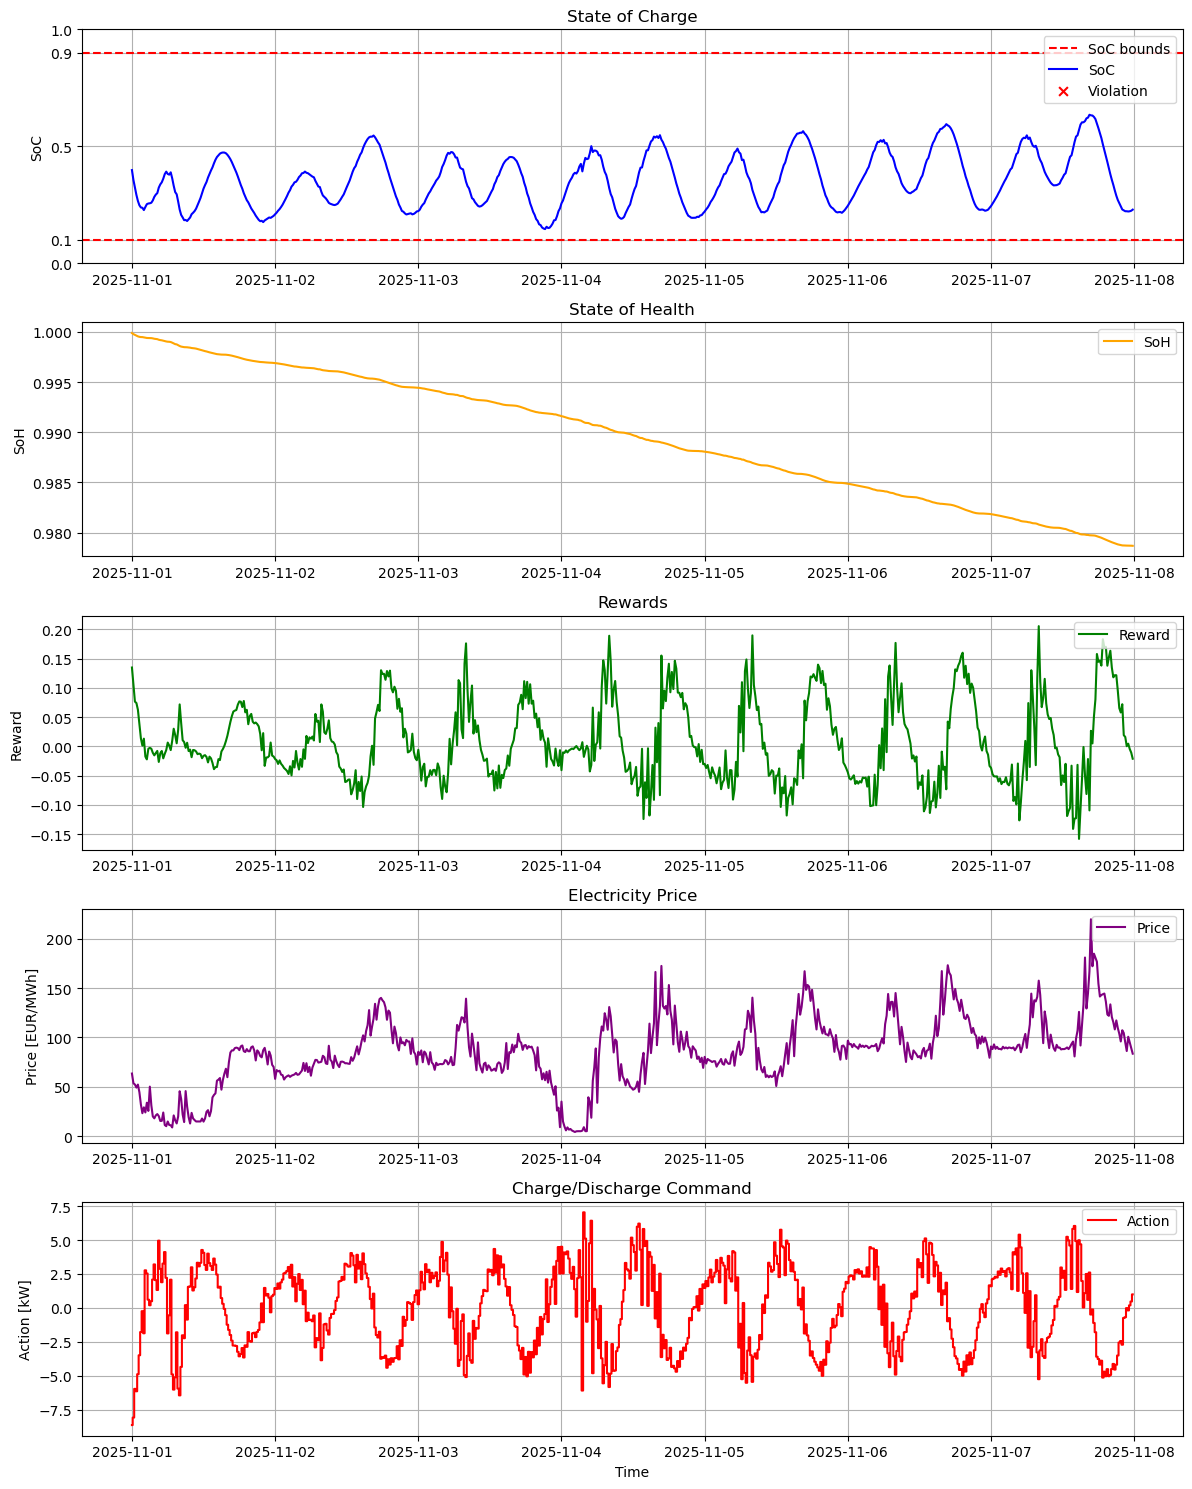

In [4]:
# Create evaluation environment on first week of November
eval_env = BatteryEnv(
    price_series=price_eval,
    demand_series=None,
    timestamps=timestamps_eval,
    dt_hours=0.25,
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=False,
    use_price_forecast=True,
    forecast_horizon_hours=3.0,
    episode_days=7.0,             # matches the eval week length
    random_start=False, 
    random_seed=123,
)

results = evaluate_rollout(
    model=sac_model,
    env=eval_env,
)

evaluate_financials(
    revenue_list=results["revenue"],
    deg_cost_list=results["deg_cost"],
    penalty_list=results["penalty"],
)

plot_bess_rollout(
    soc_list=results["soc"],
    soh_list=results["soh"],
    reward_list=results["reward"],
    price_list=results["price_true"],
    action_list=results["action"],
    violated_list=results["violated"], 
    timestamps=timestamps_eval,
)